<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-исследовательский-анализ-данных" data-toc-modified-id="Обзор-и-исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и исследовательский анализ данных</a></span></li><li><span><a href="#Увеличение-датасета-и-формирование-таргета" data-toc-modified-id="Увеличение-датасета-и-формирование-таргета-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Увеличение датасета и формирование таргета</a></span></li><li><span><a href="#Проверка-данных" data-toc-modified-id="Проверка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка данных</a></span></li><li><span><a href="#Векторизация-изображений" data-toc-modified-id="Векторизация-изображений-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Векторизация изображений</a></span></li><li><span><a href="#Векторизация-текстов" data-toc-modified-id="Векторизация-текстов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Векторизация текстов</a></span></li><li><span><a href="#Объединение-векторов" data-toc-modified-id="Объединение-векторов-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Объединение векторов</a></span></li><li><span><a href="#Обучение-модели-предсказания-соответствия" data-toc-modified-id="Обучение-модели-предсказания-соответствия-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Обучение модели предсказания соответствия</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Полносвязная-нейронная-сеть" data-toc-modified-id="Полносвязная-нейронная-сеть-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Полносвязная нейронная сеть</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Поиск изображений по запросу

Необходимо разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Разработка пройдет в 9 этапов:
1. Обзор и исследовательский анализ данных.
2. Увеличение датасета и формирование таргета.
3. Проверка данных на наличие запрещенного контента.
4. Векторизация изображений.
5. Векторизация текстовых запросов.
6. Объединение векторов.
7. Обучение модели предсказания соответствия.
8. Тестирование модели.
9. Выводы.

## Обзор и исследовательский анализ данных

Импортируем библиотеки:

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 12.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import re
from tqdm import notebook, tqdm
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import torchvision.models as models
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit, cross_val_score

import warnings
warnings.filterwarnings("ignore")

try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    PTH = '/content/gdrive/My Drive/image_search'
except Exception:
    PTH = './image_search'

Mounted at /content/gdrive/


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


Считаем датасеты и сохраним в переменные:

In [ ]:
train_dataset = pd.read_csv(PTH + '/train_dataset.csv')
test_images = pd.read_csv(PTH + '/test_images.csv')
test_queries = pd.read_csv(PTH + '/test_queries.csv', delimiter='|', index_col=0)
crowd_annotations = pd.read_csv(PTH + '/CrowdAnnotations.tsv',
                                sep='\t',
                                header=None,
                                names=['image', 'query_id', 'score_crowd', 'pos_crowd', 'neg_crowd'])
expert_annotations = pd.read_csv(PTH + '/ExpertAnnotations.tsv',
                                 sep='\t',
                                 header=None,
                                 names=['image', 'query_id', '1_exp', '2_exp', '3_exp'])

Выведем на экран первые, последние и случайные пять строк каждой таблицы, а также общую информацию. Создадим для этого собственную функцию:

In [ ]:
def total_view(df: pd.DataFrame, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return display(pd.concat([
                              df.head(n_rows),
                              df.sample(n_rows, random_state=seed),
                              df.tail(n_rows)
                             ]))

In [ ]:
total_view(train_dataset)
train_dataset.info()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1221,429851331_b248ca01cd.jpg,3123351642_3794f2f601.jpg#2,A snowboarder jumps high in the air over a sno...
85,1262583859_653f1469a9.jpg,2140182410_8e2a06fbda.jpg#2,The kid is on a float in the snow .
2980,2909875716_25c8652614.jpg,3737539561_d1dc161040.jpg#2,Two boys with water wings climb a tree .
4607,2309860995_c2e2a0feeb.jpg,2225231022_1632d0a5aa.jpg#2,Three young adults look towards the camera in ...
1675,3221036999_3f7b152d8a.jpg,2518508760_68d8df7365.jpg#2,A greyhound wearing a muzzle and the number si...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


В датасете `train_dataset` 3 колонки и 5822 строк. Тип данных в колонках `object` - соответствует содержащимся в них данных.
Согласно документации, в колонках содержится следующая информация:
* `image` - имя файла изображения;
* `query_id` - идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>`;
* `query_text` - текст описания.

In [ ]:
total_view(test_images)
test_images.info()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
6,3044359043_627488ddf0.jpg
26,989754491_7e53fb4586.jpg
40,3466891862_9afde75568.jpg
56,782401952_5bc5d3413a.jpg
98,2670637584_d96efb8afa.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


В `test_images` одна колонка и 100 строк, содержит имена файлов изображений из тестовой выборки.

In [ ]:
total_view(test_queries)
test_queries.info()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
227,3091962081_194f2f3bd4.jpg#2,A salt-and-pepper-haired man with beard and gl...,3091962081_194f2f3bd4.jpg
244,3142055158_01b9e4caa4.jpg#4,"While holding tight to the ball , the man in r...",3142055158_01b9e4caa4.jpg
50,1991806812_065f747689.jpg#0,a boxer punches a boxer in the face .,1991806812_065f747689.jpg
183,2887171449_f54a2b9f39.jpg#3,Woman in colorful shirt works at sewing machine .,2887171449_f54a2b9f39.jpg
278,3247693965_845b3b4349.jpg#3,A tan dog is pulling a red sled in the snow .,3247693965_845b3b4349.jpg


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


В `test_queries` 3 колонки и 500 строк. Тип данных в колонках `object` - соответствует содержащимся в них данных.
Согласно документации, в колонках содержится следующая информация:
* `query_id` - идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>`;
* `query_text` - текст описания;
* `image` - имя файла изображения.

In [ ]:
total_view(crowd_annotations)
crowd_annotations.info()

,image,query_id,score_crowd,pos_crowd,neg_crowd
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
39456,3627011534_485f667b10.jpg,2646116932_232573f030.jpg#2,0.000000,0,3
33993,3442242092_e579538d82.jpg,3222055946_45f7293bb2.jpg#2,0.000000,0,3
3957,166507476_9be5b9852a.jpg,224369028_b1ac40d1fa.jpg#2,0.000000,0,3
610,115684808_cb01227802.jpg,115684808_cb01227802.jpg#2,0.666667,2,1
13966,2544426580_317b1f1f73.jpg,732468337_a37075225e.jpg#2,0.000000,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   score_crowd  47830 non-null  float64
 3   pos_crowd    47830 non-null  int64  
 4   neg_crowd    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


В `crowd_annotations` 5 колонок и 47830 строк. Тип данных в колонках `float64`, `int64` и `object` - соответствует содержащимся в них типам данных. , в колонках содержится следующая информация:
* `image` - имя файла изображения;
* `query_id` - идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>`;
* `score_crowd` - доля людей, подтвердивших, что описание соответствует изображению;
* `pos_crowd` - количество человек, подтвердивших, что описание соответствует изображению;
* `neg_crowd` - количество человек, подтвердивших, что описание не соответствует изображению.

In [ ]:
total_view(expert_annotations)
expert_annotations.info()

,image,query_id,1_exp,2_exp,3_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5581,544576742_283b65fa0d.jpg,2763044275_aa498eb88b.jpg#2,1,1,1
1573,2495931537_9b8d4474b6.jpg,3393343330_b13df4d8ec.jpg#2,1,1,1
5570,542317719_ed4dd95dc2.jpg,2963573792_dd51b5fbfb.jpg#2,3,3,3
4311,3498327617_d2e3db3ee3.jpg,2704934519_457dc38986.jpg#2,2,2,2
935,2197275664_fabcf3424b.jpg,3243588540_b418ac7eda.jpg#2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   1_exp     5822 non-null   int64 
 3   2_exp     5822 non-null   int64 
 4   3_exp     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В `expert_annotations` 5 колонок и 5822 строк. Тип данных в колонках `int64` и `object` - соответствует содержащимся в них типам данных. , в колонках содержится следующая информация:
* `image` - имя файла изображения;
* `query_id` - идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>`;
* `1_exp`, `2_exp`, `3_exp` - оценки трех экспертов по шкале от 1 (изображение и запрос совершенно не соответствуют друг другу) до 4 (запрос и текст соответствуют полностью).

В папке `train_images` содержатся изображения для тренировки модели:

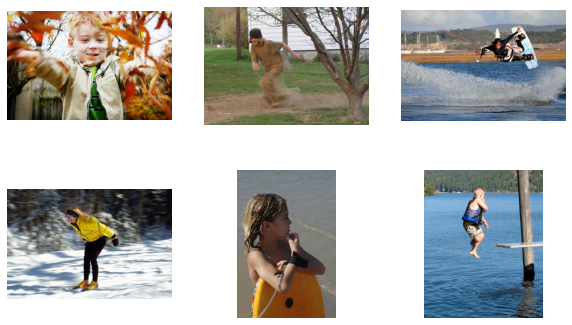

In [ ]:
plt.figure(figsize=(10, 6))
cnt = 1
names = random.choices(os.listdir(PTH + '/train_images'), k=6)
for filename in names:
    if filename[-3:] == 'jpg':
        full_path = os.path.join(PTH + '/train_images', filename)
        if os.path.isfile(full_path):
            img = Image.open(full_path).convert('RGB')
            plt.subplot(2, 3, cnt)
            plt.axis('off')
            plt.imshow(img)
            cnt += 1

В папке `test_images` содержатся изображения для тестирования модели:

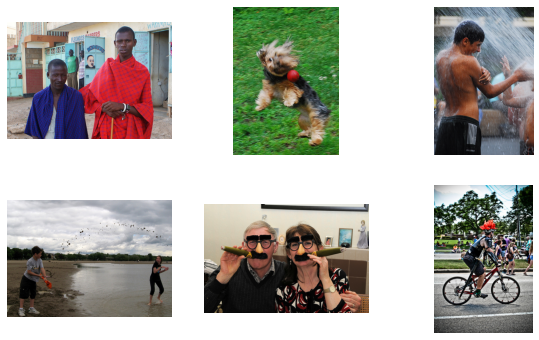

In [ ]:
plt.figure(figsize=(10, 6))
cnt = 1
names = random.choices(os.listdir(PTH + '/test_images'), k=6)
for filename in names:
    if filename[-3:] == 'jpg':
        full_path = os.path.join(PTH + '/test_images', filename)
        if os.path.isfile(full_path):
            img = Image.open(full_path).convert('RGB')
            plt.subplot(2, 3, cnt)
            plt.axis('off')
            plt.imshow(img)
            cnt += 1

**Выводы:**
- в train_dataset собрано 5822 пары изображений и текстовых запросов, в test_images и test_queries список изображений и текстовых запросов для тестирования модели, в crowd_annotations собрано 47830 пар изображений и текстовых запросов с краудсорс оценками (за счет них можно увеличить тренировочный датасет), в expert_annotations 5822 пар изображений и текстовых запросов с оценками экспертов;
- среди изображений часто встречаются дети и собаки, в остальном изображения довольно разнообразные;
- среди текстовых запросов и изображений присутствует запрещенный контент - дети, не достигшие 16 лет.

## Увеличение датасета и формирование таргета

Увеличим тренировочный датасет за счет пар изображений и текстовых запросов из crowd_annotations:

In [ ]:
# оставим уникальные текстовые запросы
tmp_train_dataset = train_dataset.drop_duplicates('query_id')
# добавим текстовые запросы к соответствующим идентификаторам текстового описания в crowd_annotations
crowd_annotations = crowd_annotations.merge(tmp_train_dataset[['query_text', 'query_id']],
                                            on='query_id',
                                            how='left')

# добавим пары изображений и текстовых запросов из crowd_annotations в train_dataset
train_dataset = pd.concat([train_dataset, crowd_annotations[['image', 'query_id', 'query_text']]])
# удалим дубликаты и строки с пропусками в 'query_text'
train_dataset = train_dataset.drop_duplicates()
train_dataset = train_dataset.dropna()
total_view(train_dataset)
train_dataset.shape

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
11707,2458269558_277012780d.jpg,2128119486_4407061c40.jpg#2,A little boy is eating something and got it al...
35021,3482974845_db4f16befa.jpg,3673165148_67f217064f.jpg#2,A dog standing on a beach .
34889,3480051754_18e5802558.jpg,3099923914_fd450f6d51.jpg#2,People are enjoying drinks at a table outside ...
35876,3504881781_6a842e043b.jpg,3125309108_1011486589.jpg#2,rugby match
1422,311146855_0b65fdb169.jpg,224369028_b1ac40d1fa.jpg#2,A young girl standing in front of a fountain


(50214, 3)

Теперь тренировочный датасет состоит из 50214 записей. Добавим краудсорс оценки и оценки экспертов к `train_dataset`, для этого объединим таблицы `crowd_annotations` и `expert_annotations` с `train_dataset`:

In [ ]:
df = train_dataset.merge(crowd_annotations[['image', 'query_id', 'score_crowd']],
                         on=['image', 'query_id'],
                         how='left'
                        )

df = df.merge(expert_annotations,
              on=['image', 'query_id'],
              how='left'
                        )

total_view(df)
len(df)

,image,query_id,query_text,score_crowd,1_exp,2_exp,3_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1.0,1.0,1.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1.0,2.0,2.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,4.0,4.0,4.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0
49025,745880539_cd3f948837.jpg,2822290399_97c809d43b.jpg#2,"A white dog runs along a path , trailing a lea...",0.000000,NaN,NaN,NaN
34022,3295391572_cbfde03a10.jpg,2861932486_52befd8592.jpg#2,A man looking at produce .,0.000000,NaN,NaN,NaN
42284,3613955682_3860e116cf.jpg,2603792708_18a97bac97.jpg#2,Two people walking along the beach at sunset t...,0.000000,NaN,NaN,NaN
16506,2450299735_62c095f40e.jpg,2963573792_dd51b5fbfb.jpg#2,A young girl is sliding down a slide at a play...,0.250000,NaN,NaN,NaN
1323,2603792708_18a97bac97.jpg,2183227136_8bb657846b.jpg#2,A person on the beach beside the ocean at suns...,0.666667,3.0,4.0,4.0


50214

Проверим, что каждая пара имеет хотя бы одну оценку:

In [ ]:
df[(df['score_crowd'].isna()) & (df['1_exp'].isna())].sum()

image          0.0
query_id       0.0
query_text     0.0
score_crowd    0.0
1_exp          0.0
2_exp          0.0
3_exp          0.0
dtype: float64

Напишем функцию, возвращающую оценку соответствия текстового описания и картинки от 0 до 1, где 0 - изображение и запрос совершенно не соответствуют друг другу и 1 - изображение и запрос соответствуют полностью. Записи, где все экперты поставили разные оценки, удалим:

In [ ]:
scores_dict = {1: 0,
               2: 1/3,
               3: 2/3,
               4: 1}
def scores(row):
    '''Возвращает оценку соответствия текста картинке от 0 до 1'''
    if math.isnan(row['1_exp']):
        return row['score_crowd']
    
    elif len({row['1_exp'], row['2_exp'], row['3_exp']}) == 3:
        return 10
    
    elif math.isnan(row['score_crowd']):
        expert_scores = [row['1_exp'], row['2_exp'], row['3_exp']]
        main_score = [n for n, c in Counter(expert_scores).items() if c>1][0]
        return scores_dict[main_score]
    
    else:
        expert_scores = [row['1_exp'], row['2_exp'], row['3_exp']]
        main_score = [n for n, c in Counter(expert_scores).items() if c>1][0]
        return 0.4 * row['score_crowd'] + 0.6 * scores_dict[main_score]
    
df['scores'] = df.apply(scores, axis=1)
df = df[df['scores'] <= 1]
df = df.reset_index(drop=True)
total_view(df)
len(df)

,image,query_id,query_text,score_crowd,1_exp,2_exp,3_exp,scores
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1.0,1.0,1.0,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1.0,2.0,2.0,0.200000
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,4.0,4.0,4.0,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0,0.000000
17108,247637795_fdf26a03cf.jpg,247637795_fdf26a03cf.jpg#2,A woman holding a black leash and a man lookin...,1.000000,NaN,NaN,NaN,1.000000
13815,2280525192_81911f2b00.jpg,317383917_d8bfa350b6.jpg#2,three black dogs and a white dog are standing ...,0.000000,NaN,NaN,NaN,0.000000
47101,506367606_7cca2bba9b.jpg,2666205903_8d287669e1.jpg#2,A girls in a blue shirt holds a flower while s...,0.000000,NaN,NaN,NaN,0.000000
25990,2981702521_2459f2c1c4.jpg,3497224764_6e17544e0d.jpg#2,A woman writing while standing by men .,0.000000,NaN,NaN,NaN,0.000000
9854,1786425974_c7c5ad6aa1.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a...",0.666667,NaN,NaN,NaN,0.666667


50088

**Выводы:**
- обучающий датасет увеличен за счет пар изображений и текстовых описаний из crowd_annotations, дубликаты удалены;
- к обучающему датасету добавлены оценки экспертов и краудов и выведена общая оценка соответствия изображения тексту от 0 до 1;
- из обучающего датасета удалено 126 пар "изображение - текст" в случаях, когда все оценки экспертов были разные, размер обучающего датасета составил 50088 записей.

## Проверка данных

Для соблюдения законодательства необходимо скрыть весь запрещенный контент. Составим множество имен изображений, в текстовом описании которых попадается запрещенный контент и отфильтруем датасет:

In [ ]:
banned_words = ['kid', 'child', 'baby', 'babe', 'babies', 'infant', 'youngster', 'children',
                'toddler', 'newborn', 'boy', 'girl', 'teen', 'juvenile', 'stripling']

banned_images = set()
for idx in range(len(df)):
    for word in banned_words:
        if word in df.loc[idx, 'query_text']:
            banned_images.add(df.loc[idx, 'query_id'].split('#')[0])
len(banned_images)

282

In [ ]:
df = df.query('image not in @banned_images').reset_index(drop=True)

total_view(df)
len(df)

,image,query_id,query_text,score_crowd,1_exp,2_exp,3_exp,scores
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,1.0,1.0,1.0,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0,0.000000
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0,0.000000
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0,0.000000
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.0,1.0,1.0,0.000000
12905,2589241160_3832440850.jpg,2103568100_5d018c495b.jpg#2,A white dog is walking through a river that ru...,0.000000,NaN,NaN,NaN,0.000000
23824,3285993030_87b0f1d202.jpg,500446858_125702b296.jpg#2,A white dog is running on gravel away from two...,0.000000,NaN,NaN,NaN,0.000000
17600,2968182121_b3b491df85.jpg,2358898017_24496b80e8.jpg#2,A dog races along the grassy track .,0.000000,NaN,NaN,NaN,0.000000
1638,3393343330_b13df4d8ec.jpg,2078311270_f01c9eaf4c.jpg#2,Two women crossing the street on a cold day,NaN,1.0,1.0,1.0,0.000000
30986,3647750811_395fbd397e.jpg,2510020918_b2ca0fb2aa.jpg#2,A young boy dressed in a black hoodie crawling...,0.000000,NaN,NaN,NaN,0.000000


36169

**Выводы:**
- из датасета удалено 13 919 пары изображений и текстового описания, попадающих под запрещенный контент, для обучения осталось 36 169 записей.

## Векторизация изображений
Проведем векторизацию изображений с помощью конволюционных слоев модели ResNet18, предобученной на датасете ImageNet. Создадим свой класс Dataset, чтобы Dataloader передавал изображения в нужном порядке:

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, image_list, root_dir, transform=None):
        self.image_names = image_list
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        img_name = os.path.join(self.root_dir, self.image_names[idx])
        img = Image.open(img_name).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        return img

In [ ]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)
    
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(DEVICE)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def image_embeddings(model, image_list, root_dir, batch_size, transform=None):
    '''Проводит изображения через конволюционные слои и возвращает массив полученных векторов'''
    my_dataset = ImageDataset(image_list=image_list, root_dir=root_dir, transform=transform)
    my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    
    image_tensors = []

    for x_batch in notebook.tqdm(my_dataloader):
        x_batch = x_batch.to(DEVICE)
        output_tensor = model(x_batch)
        n_size = output_tensor.shape[0]
        image_tensors.append(output_tensor.reshape(n_size, -1).cpu())
    
    return np.concatenate(image_tensors)

Подготовим массив уникальных названий изображений, чтобы оптимально использовать ресурсы, получим векторы изображений и добавим их в датасет:

In [ ]:
images_arr = np.unique(df['image'])

image_emb = image_embeddings(resnet,
                            images_arr, 
                            PTH + '/train_images/',
                            128,
                            preprocess)
image_emb.shape

  0%|          | 0/6 [00:00<?, ?it/s]

(718, 512)

In [ ]:
image_vecs = pd.DataFrame(np.concatenate((images_arr[:, np.newaxis], image_emb), axis=1)) \
               .rename(columns={0: 'image'})
total_view(image_vecs)

,image,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,1056338697_4f7d7ce270.jpg,0.693978,3.031816,2.91699,0.951917,0.936228,1.245221,0.826545,1.108062,0.169697,...,0.444237,0.717755,0.294675,0.728791,1.153809,0.750846,1.196696,0.085011,1.05686,0.098235
1,1082379191_ec1e53f996.jpg,0.580881,0.636028,1.235313,1.239307,1.264691,0.385739,0.521415,1.737717,0.354155,...,0.707459,0.972238,0.291917,1.237111,0.27092,0.241001,0.039484,0.229987,2.469587,0.110243
2,1084040636_97d9633581.jpg,0.891784,0.699766,0.743489,0.213387,1.508293,1.159896,1.46333,3.576004,0.260949,...,1.121155,0.670597,0.416131,2.027011,0.029152,0.080594,1.536918,0.533675,1.39479,0.070406
3,1107246521_d16a476380.jpg,1.173784,1.277598,1.220057,0.511007,1.628955,0.791942,0.256375,0.031555,0.556466,...,0.672688,0.696747,0.36828,1.062171,0.204911,0.822542,0.09243,1.479732,0.760468,0.132309
4,1119015538_e8e796281e.jpg,0.868183,0.421635,0.035824,0.204043,0.285496,0.197903,0.847772,0.728671,1.442088,...,0.510158,0.548297,0.028083,0.96442,1.442032,0.544692,0.352936,1.391847,0.590311,0.168133
430,3254817653_632e840423.jpg,0.160129,1.684286,2.362766,0.117568,0.442466,0.5746,0.874467,0.185039,0.3686,...,1.079215,0.979484,0.206078,1.06081,0.281345,0.838534,0.700678,0.313355,0.168892,0.330777
209,2621415349_ef1a7e73be.jpg,2.199279,1.65224,2.472459,0.968297,0.613413,0.603524,2.909678,0.313736,1.213049,...,0.678829,0.132319,1.314379,2.436487,5.474365,1.417144,0.014815,1.559048,0.415333,0.64413
358,3116769029_f5a76f04ba.jpg,1.223623,1.209546,2.335009,1.691313,0.071567,0.045716,0.29732,0.831132,0.119096,...,0.363779,1.357861,1.945478,1.317077,2.024807,0.67504,0.839947,1.862905,1.187555,1.022997
634,400851260_5911898657.jpg,0.176288,0.207752,0.076659,0.761085,0.039793,0.862652,0.111267,0.523213,1.939122,...,0.116814,0.417473,0.808735,0.07031,2.251283,0.220719,0.253672,0.1521,4.374672,1.120789
63,200771289_31902164a7.jpg,0.278248,0.586326,1.404309,0.476133,0.934505,0.816505,0.206303,0.53165,1.48076,...,0.253474,1.390324,0.814612,1.982175,1.427453,0.313249,1.284355,1.214247,0.353158,0.075643


**Выводы:**
- изображения переведены в векторы размером 512 с помощью конволюционных слоев модели ResNet18, предобученной на датасете ImageNet;
- полученные векторы сохранены в датасете `image_vecs`.

## Векторизация текстов

Напишем функцию с использованием BERT для получения эмбеддингов, количество токенов укажем равным 50.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(DEVICE)

class TextDataset(Dataset):

    def __init__(self, text):
        self.text = text

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        tokenized = tokenizer.encode(text,
                                     add_special_tokens=True,
                                     truncation=True,
                                     max_length = 50,
                                     padding='max_length'
                                     )

        padded = torch.LongTensor(np.array(tokenized))
        attention_mask = torch.LongTensor(np.where(padded != 0, 1, 0))
        return padded, attention_mask

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def text_embeddings(model, tokenizer, data, batch_size):
    '''Возвращает эмбеддинги'''
    text_dataset = TextDataset(data)
    text_dataloader = DataLoader(text_dataset, batch_size=batch_size)
    embeddings = []

    with torch.no_grad():
        for text, att_mask in notebook.tqdm(text_dataloader):
            text = text.to(DEVICE)
            att_mask = att_mask.to(DEVICE)
            outp = model(text, att_mask)
            embeddings.append(outp[0][:,0,:].cpu().numpy())
            
    return np.concatenate(embeddings)

Подготовим массив уникальных текстовых запросов, чтобы оптимально использовать ресурсы, получим эмбеддинги и добавим их в датасет:

In [ ]:
text_df = df[['query_id', 'query_text']].drop_duplicates()

text_emb = text_embeddings(bert_model, tokenizer, text_df['query_text'].values, 128)
text_emb.shape

  0%|          | 0/8 [00:00<?, ?it/s]

(977, 768)

In [ ]:
text_vecs = pd.DataFrame(np.concatenate((text_df['query_id'].values[:, np.newaxis], text_emb), axis=1)) \
               .rename(columns={0: 'query_id'})
total_view(text_vecs)

,query_id,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,2549968784_39bfbe44f9.jpg#2,-0.179624,-0.39367,-0.086465,0.025088,0.154785,-0.098076,0.357146,0.552073,-0.465391,...,-0.267759,-0.31003,-0.024312,0.060281,-0.067874,0.414335,0.083891,-0.048825,0.401808,0.235845
1,2718495608_d8533e3ac5.jpg#2,-0.101045,-0.37871,-0.055245,-0.124489,0.004449,-0.076603,-0.035449,0.693639,-0.293523,...,-0.115461,-0.248783,0.217876,0.032913,0.104052,0.134409,-0.130084,-0.257901,0.360228,0.127657
2,3181701312_70a379ab6e.jpg#2,0.042615,-0.240773,-0.181094,-0.147856,0.165562,-0.072404,0.222482,0.787704,-0.226082,...,-0.049241,-0.156374,0.08246,-0.097126,0.116486,0.218627,-0.107883,-0.213647,0.429329,0.208729
3,3207358897_bfa61fa3c6.jpg#2,-0.098318,-0.299185,-0.054403,-0.122299,-0.042567,-0.024373,-0.031708,0.574342,-0.399449,...,-0.101414,-0.08359,0.13859,0.067901,0.183706,0.040504,-0.009348,-0.021518,0.230868,0.212783
4,3286822339_5535af6b93.jpg#2,-0.409066,-0.198579,-0.202964,-0.206265,0.206245,0.034473,0.171306,0.975374,-0.461659,...,0.148746,-0.282071,0.067357,-0.011632,0.181188,-0.398581,-0.238885,-0.154388,0.42174,0.129614
867,2868575889_2c030aa8ae.jpg#2,-0.028143,-0.280152,-0.404985,0.017444,0.122128,-0.076954,0.059582,0.860324,-0.26088,...,-0.148495,-0.222036,0.040054,-0.10392,0.258705,0.026397,-0.217787,-0.177027,0.517844,0.019005
973,3584534971_b44f82c4b9.jpg#2,-0.253843,-0.239996,-0.137263,0.096266,0.431497,-0.386753,0.378948,0.192088,-0.140654,...,-0.152633,-0.071609,0.005484,-0.171371,0.081658,-0.122083,-0.169827,0.107709,0.211853,0.205173
603,468102269_135938e209.jpg#2,-0.037343,-0.264829,-0.214844,-0.116142,0.055751,0.011577,0.000086,0.604929,-0.425186,...,-0.150244,-0.275353,0.255533,0.047617,-0.010387,0.183408,0.025078,0.052655,0.543137,0.169207
63,3239021459_a6b71bb400.jpg#2,-0.088162,0.072475,-0.196731,-0.211702,0.006133,-0.206537,0.142065,0.258164,-0.477121,...,-0.064584,0.220703,-0.020465,0.01041,0.292314,0.25369,0.013296,-0.040891,0.310628,0.129207
645,2623930900_b9df917b82.jpg#2,0.011809,-0.221032,0.037483,-0.139991,0.197041,-0.287743,-0.003806,0.602901,-0.296635,...,-0.209321,-0.208283,0.134038,-0.023419,-0.025813,0.453446,-0.220026,-0.1699,0.369987,0.209348


**Выводы:**
- получены эмбеддинги текстовых запросов размером 768 с помощью модели BERT 'distilbert-base-uncased';
- полученные векторы сохранены в датафрейме `text_vecs`.

## Объединение векторов

Объединим векторы изображений и векторы текстов, создадим объект GroupShuffleSplit для кросс-валидации линейной регрессии, а также сформируем загрузчики данных для полносвязной нейронной сети:

In [ ]:
train_df = df[['image', 'query_id']].merge(image_vecs,
                                           on='image',
                                           how='left'
                                          )

train_df = train_df.merge(text_vecs,
                          on='query_id',
                          how='left'
                         )
train_df = train_df.drop(['image', 'query_id'], axis=1).to_numpy(dtype='f')
print(train_df.shape)
train_df

(36169, 1280)


array([[ 0.69397825,  3.031816  ,  2.91699   , ..., -0.04882472,
         0.40180784,  0.23584518],
       [ 0.42887765,  1.151236  ,  1.1857202 , ..., -0.04882472,
         0.40180784,  0.23584518],
       [ 2.199279  ,  1.65224   ,  2.472459  , ..., -0.04882472,
         0.40180784,  0.23584518],
       ...,
       [ 1.8362813 ,  0.53782815,  0.54931843, ..., -0.16202308,
         0.32617983,  0.31061113],
       [ 1.8362813 ,  0.53782815,  0.54931843, ..., -0.31508568,
         0.32330838,  0.27168146],
       [ 1.8362813 ,  0.53782815,  0.54931843, ..., -0.22509244,
         0.45920458,  0.18788853]], dtype=float32)

In [ ]:
# для линейной регрессии
gss_lr = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=42)

In [ ]:
# для полносвязной нейронной сети
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=train_df, y=df['scores'], groups=df['image']))
X_train, X_val, y_train, y_val = train_df[train_indices], train_df[test_indices], df.loc[train_indices, 'scores'], df.loc[test_indices, 'scores']

print('X_train:', X_train.shape, '\n',
      'y_train:', y_train.shape, '\n',
      'X_val:', X_val.shape, '\n',
      'y_val:', y_val.shape)

X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val.values)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

X_train: (25068, 1280) 
 y_train: (25068,) 
 X_val: (11101, 1280) 
 y_val: (11101,)


**Выводы:**
- размерность конкатенированного вектора эмбеддингов изображения и текстового описания составляет 1280;
- для обучения модели линейной регрессии создан объект GroupShuffleSplit;
- для обучения нейронной сети сформированы загрузчики данных `train_dataloader` и `val_dataloader` с размером батча 128.

## Обучение модели предсказания соответствия

Так как мы решаем задачу регрессии, для оценки качества моделей будем использовать метрику RMSE, потому что ее величина выражена в тех же единицах измерения, что и целевая переменная, что упрощает ее интерпретацию, а также потому что RMSE чувствительна к аномальным значениям. В данном случае (когда необходимо предсказать значение от 0 до 1), метрика должна быть как можно меньше 1.

### LinearRegression

In [ ]:
model_lr = LinearRegression()

scores_lr = cross_val_score(model_lr,
                            train_df,
                            df['scores'],
                            cv=gss_lr.split(X=train_df,
                                            y=df['scores'],
                                            groups=df['image']),
                            scoring='neg_root_mean_squared_error')

print('Средняя оценка качества модели (rmse):', -1 * np.mean(scores_lr))

Средняя оценка качества модели (rmse): 842.9249915421171


### Полносвязная нейронная сеть

Создадим полносвязную нейронную сеть с двумя скрытыми слоями, функциями активации ReLU и нормализацией BatchNorm:

In [ ]:
class Net(nn.Module):
    
    def __init__(self,
                 n_in_neurons,
                 n_hidden_neurons_1,
                 n_hidden_neurons_2,
                 n_out_neurons):
        super().__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

        
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0, std=0.5)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0, std=0.5)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.normal_(self.fc3.bias, mean=0, std=0.5)

        
    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.act(self.bn2(self.fc2(x)))
        x = self.fc3(x)

        return x

Обучим сеть, параметр learning rate будем регулировать с помощью `torch.optim.lr_scheduler.ReduceLROnPlateau`:

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

best_epoch = None
best_rmse = 99999
rmse_train = 99999


net = Net(X_train.shape[1], 512, 256, 1).to(DEVICE)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.001)

loss_tr = []
loss_val = []
rmse_tr = []
rmse_val = []

for epoch in notebook.tqdm(range(80)):
    if epoch % 10 == 0 or epoch == 79:
        print('epoch', epoch)
    net.train()
    avg_loss = 0
    avg_loss_val = 0
    avg_rmse = 0
    avg_rmse_val = 0
    
    for X_batch, Y_batch in train_dataloader:
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)
        optimizer.zero_grad()
        outp = net(X_batch).flatten(start_dim=-2)
        loss_value = loss(outp, Y_batch)
        loss_value.backward()
        optimizer.step()
        avg_loss += loss_value / len(train_dataloader)
        avg_rmse += mean_squared_error(Y_batch.cpu(),
                                       outp.cpu().detach().numpy(),
                                       squared=False) / len(train_dataloader)
    scheduler.step(avg_loss)
    loss_tr.append(avg_loss.cpu().detach())
    rmse_tr.append(avg_rmse)
    
    if epoch % 10 == 0 or epoch == 79:
        print('loss: %f' % avg_loss)
        print('rmse: %f' % avg_rmse)
            
    net.eval() 
    with torch.no_grad():
        for X_batch, Y_batch in val_dataloader:
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)
            preds_val = net(X_batch).flatten(start_dim=-2)
            loss_value = loss(preds_val, Y_batch)
            avg_loss_val += loss_value / len(val_dataloader)
            avg_rmse_val += mean_squared_error(Y_batch.cpu(),
                                               preds_val.cpu().numpy(),
                                               squared=False) / len(val_dataloader)
        loss_val.append(avg_loss_val.cpu().detach())
        rmse_val.append(avg_rmse_val)
            
        if epoch % 10 == 0 or epoch == 79:
            print('loss_val: %f' % avg_loss_val)
            print('rmse_val: %f' % avg_rmse_val)
        if avg_rmse_val < best_rmse:
            best_rmse = avg_rmse_val
            best_epoch = epoch
            rmse_train = avg_rmse

    torch.cuda.empty_cache()

  0%|          | 0/80 [00:00<?, ?it/s]

epoch 0
loss: 0.126611
rmse: 0.326139
loss_val: 0.084868
rmse_val: 0.283985
epoch 10
loss: 0.029624
rmse: 0.170975
loss_val: 0.049955
rmse_val: 0.219922
epoch 20
loss: 0.020940
rmse: 0.143568
loss_val: 0.048044
rmse_val: 0.215910
epoch 30
loss: 0.013325
rmse: 0.114698
loss_val: 0.050276
rmse_val: 0.221451
epoch 40
loss: 0.008945
rmse: 0.093973
loss_val: 0.048965
rmse_val: 0.218702
epoch 50
loss: 0.006451
rmse: 0.079876
loss_val: 0.048738
rmse_val: 0.217808
epoch 60
loss: 0.005188
rmse: 0.071614
loss_val: 0.048664
rmse_val: 0.217596
epoch 70
loss: 0.004357
rmse: 0.065492
loss_val: 0.046886
rmse_val: 0.213511
epoch 79
loss: 0.003617
rmse: 0.059662
loss_val: 0.045179
rmse_val: 0.209308


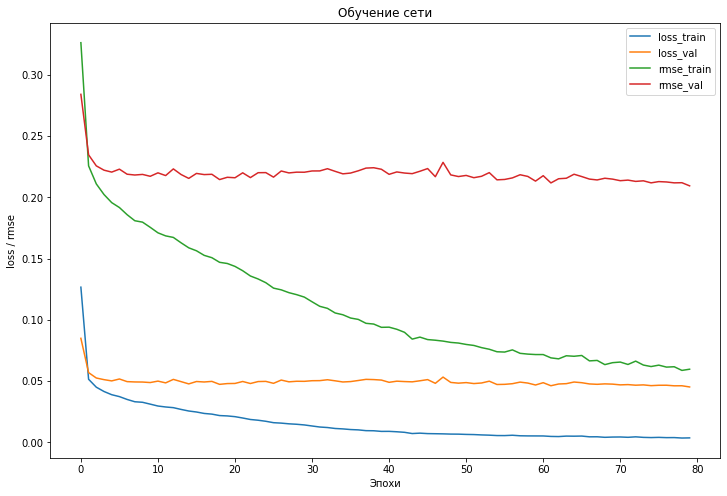

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss_tr, label="loss_train")
plt.plot(loss_val, label="loss_val")
plt.plot(rmse_tr, label="rmse_train")
plt.plot(rmse_val, label="rmse_val")
plt.legend()
plt.title('Обучение сети')
plt.xlabel('Эпохи')
plt.ylabel('loss / rmse')
plt.show()

In [ ]:
print(f'epoch: {best_epoch}', 
      f'RMSE train: {rmse_train}',
      f'RMSE val: {best_rmse}',
      sep='\n')

epoch: 79
RMSE train: 0.05966241802183949
RMSE val: 0.20930800295766744


RMSE на валидационной выборке достиг 0.21 за 80 эпох. После 80 эпох loss и rmse уже совсем перестают убывать, поэтому остановим обучение на этом.

**Выводы:**
- наименьшая метрика RMSE на валидационной выборке составила 0.21 за 80 эпох обучения полносвязной нейронной сети с двумя скрытыми слоями, функциями активации ReLU и нормализацией BatchNorm и регуляризацией learning rate.

## Тестирование модели

Получим эмбеддинги для всех тестовых изображений из папки `test_images`:

In [ ]:
image_emb_test = image_embeddings(resnet,
                                  test_images['image'].to_list(), 
                                  PTH + '/test_images/',
                                  100,
                                  preprocess)
image_emb_test.shape

  0%|          | 0/1 [00:00<?, ?it/s]

(100, 512)

Выберем случайно 10 запросов:

In [ ]:
indexes = np.random.randint(0, 499, size=10)
queries = test_queries.loc[indexes, 'query_text'].values
queries

array(['A little girl with purple hat is riding a tricycle along paved road by some farmland .',
       'A black dog jumps into the air to get a treat from its owner .',
       'A young man sits on a cliff , watching the ocean .',
       'a brown and white dog standing on the street wearing a hat , shirt and jeans .',
       'A girl on skis in snow .',
       'A woman and a younger girl , both wearing blue jackets and knit caps , slide down a hill on a snow sled , a dog running at their side .',
       'A group of children dressed for halloween stand in line with the exception of one girl .',
       'A white dog and a black dog in a field .',
       'A little girl with purple hat is riding a tricycle along paved road by some farmland .',
       'A boy is flying a kite and smiling at the camera .'], dtype=object)

Напишем функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики, либо дисклеймер, если выявлен запрещенный контент:

In [ ]:
def image_search(text, tokenizer, text_model, img_arr, model, img_names):
    '''Принимает на вход текстовое описание, делает его векторизацию
    и возвращает картинку с максимальным значением метрики, либо дисклеймер,
    если выявлен запрещенный контент.
    '''

    for word in banned_words:
        if word in text:
            return 'This image is unavailable in your country in compliance with local laws'
    
    tokenized = tokenizer.encode(text,
                                 add_special_tokens=True,
                                 truncation=True,
                                 max_length = 50,
                                 padding='max_length'
                                )

    padded = torch.LongTensor(np.array(tokenized)[np.newaxis, :])
    attention_mask = torch.LongTensor(np.where(padded != 0, 1, 0)[np.newaxis, :])
    outp = 0
    with torch.no_grad():
        padded = padded.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        outp = text_model(padded, attention_mask)
        outp = outp[0][:,0,:].cpu().numpy()
        
    text_arr = np.ones((img_arr.shape[0], 1)) * outp
    X = np.concatenate((img_arr, text_arr), axis=1)
    
    model.eval()
    with torch.no_grad():
        X = torch.FloatTensor(X)
        X = X.to(DEVICE)
        preds_val = net(X).flatten(start_dim=-2)
        idx = np.argmax(preds_val.cpu().numpy())
        name = img_names.loc[idx, 'image']
    
    return name

Протестируем работу модели на выбранных текстовых описаниях:

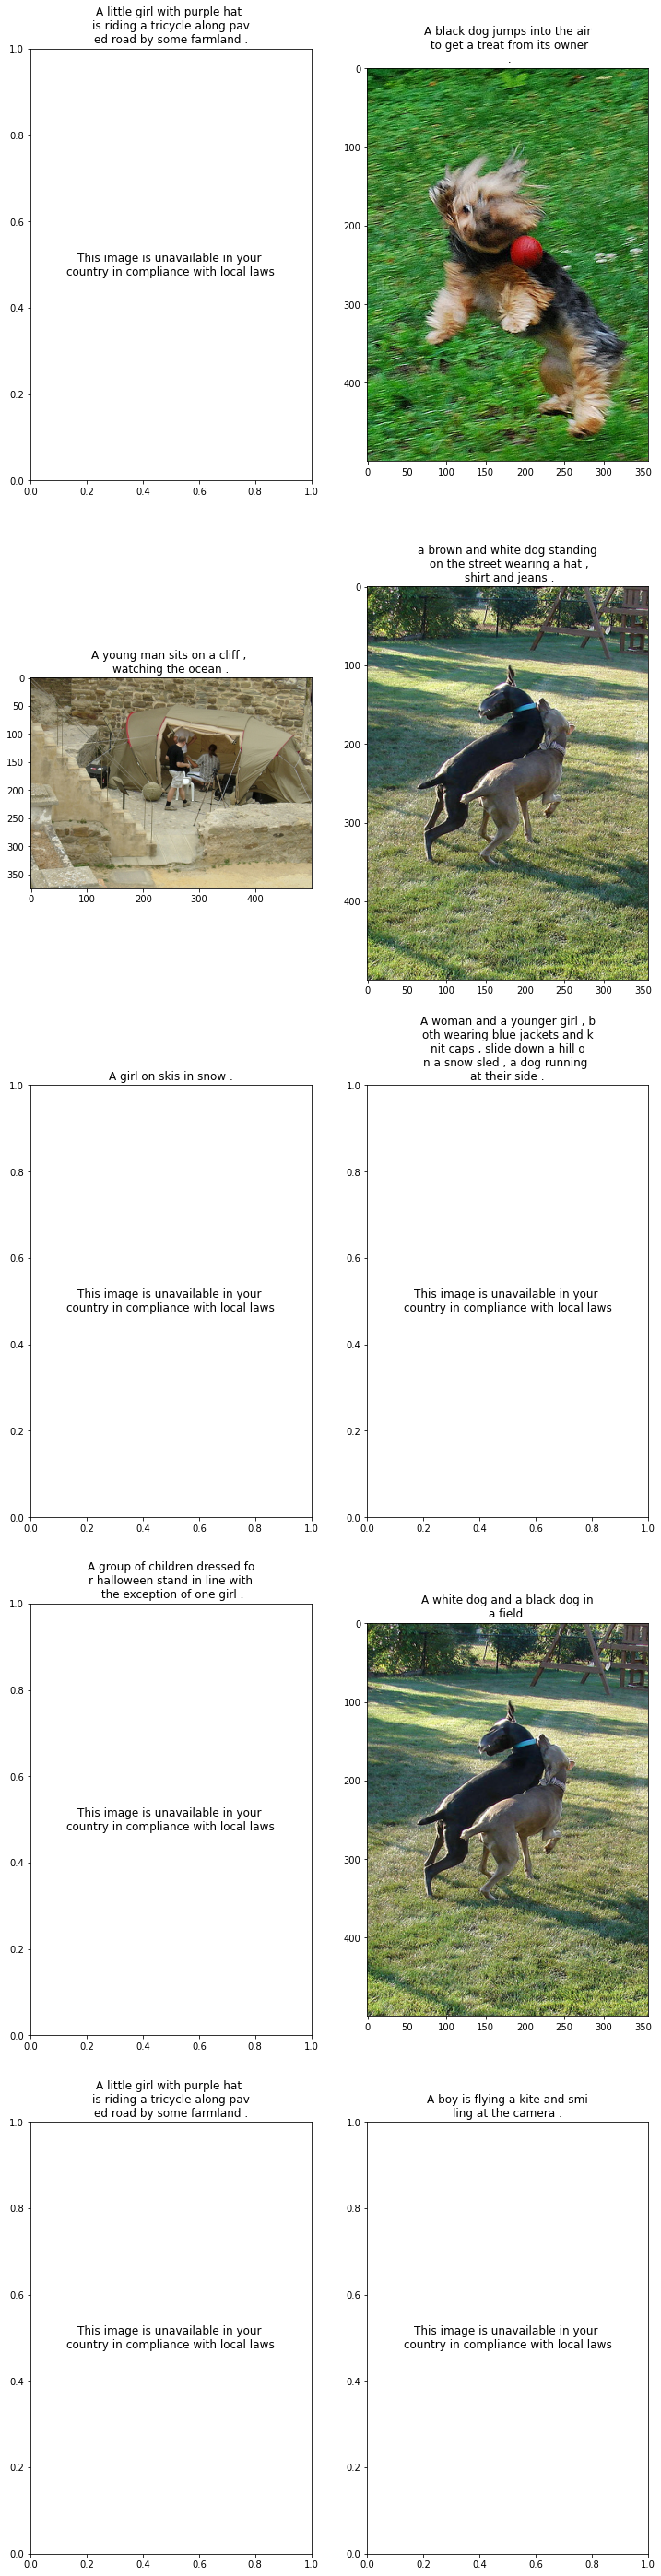

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 50))
cnt = 0
for fig_x in ax.flatten():
    query = queries[cnt]
    result = image_search(query, tokenizer, bert_model, image_emb_test, net, test_images)
    if result[-4:] == '.jpg':
        img = Image.open(os.path.join(PTH + '/test_images', result)).convert('RGB')
        fig_x.imshow(img)
        
    else:
        fig_x.text(0.5, 0.5,
                   'This image is unavailable in your \ncountry in compliance with local laws',
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=fig_x.transAxes,
                   fontsize='large')
    chunks, chunk_size = len(query), 30
    fig_x.title.set_text("\n".join(
        [query[i : i + chunk_size] for i in range(0, chunks, chunk_size)]))
    cnt += 1

## Выводы
- лучше всего с поставленной задачей справляется полносвязная нейронная сеть с двумя скрытыми слоями, функциями активации ReLU, нормализацией BatchNorm и регуляризацией learning rate. RMSE достиг 0.21 за 80 эпох обучения;
- модель достаточно хорошо определяет собак, это может быть связано с тем, что в датасете ImageNet, на котором была предобучения сверточная сеть, очень много разных классов, посвященных собакам;
- с людьми и погодными условями дела обстоят значительно хуже, модель путает снег и воду;
- в целом, проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим, нужно только собрать больше данных для обучения модели;
- также можно попробовать поиск изображений используя косинусное расстояние.